# Version 1 Simulation

The first version of this series is a basic control model. Given an elevation profile $H(x)$ and a time target, minimize energy usage.
We assume the time target is constant, since we are racing at a given overall pace. In other words, we already know the average speed $E(V) = dist/time$

In [1]:
import jax.numpy as jnp
from jax import jit, vmap, lax
from jax import random
import matplotlib.pyplot as plt

@jit
def _cov_math(t, s, H):
    return 0.5 * (jnp.abs(t) ** 2 * H + jnp.abs(s) ** 2 * H - jnp.abs(t - s) ** 2 * H)


def _fbm_covariance(n, H) -> jnp.ndarray:
    tidx = jnp.arange(1, n + 1)
    t, s = jnp.meshgrid(tidx, tidx)

    # fBm covariance equation from wikipedia
    cov = 0.5 * (jnp.abs(t) ** 2 * H + jnp.abs(s) ** 2 * H - jnp.abs(t - s) ** 2 * H)
    return cov

# generate terrain using fractional brownian motion
def gen_elevation_profile(rngkey: random.PRNGKey, n_steps: int, H: float):
    t = jnp.linspace(0,1,n_steps)
    cov = _fbm_covariance(n_steps, H)
    # using the "method 1" (cholesky decomposition)
    sigma = jnp.linalg.cholesky(cov)
    # create a vector of n_steps gaussian normal values
    v = random.normal(rngkey, shape=(n_steps))
    # convert these to fbm lines

    fbm_samples = sigma * v

    return t, fbm_samples




An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[[nan -0. -0. ... -0. -0. -0.]
 [nan nan -0. ... -0. -0. -0.]
 [nan nan nan ... -0. -0. -0.]
 ...
 [nan nan nan ... nan -0. -0.]
 [nan nan nan ... nan nan -0.]
 [nan nan nan ... nan nan nan]]


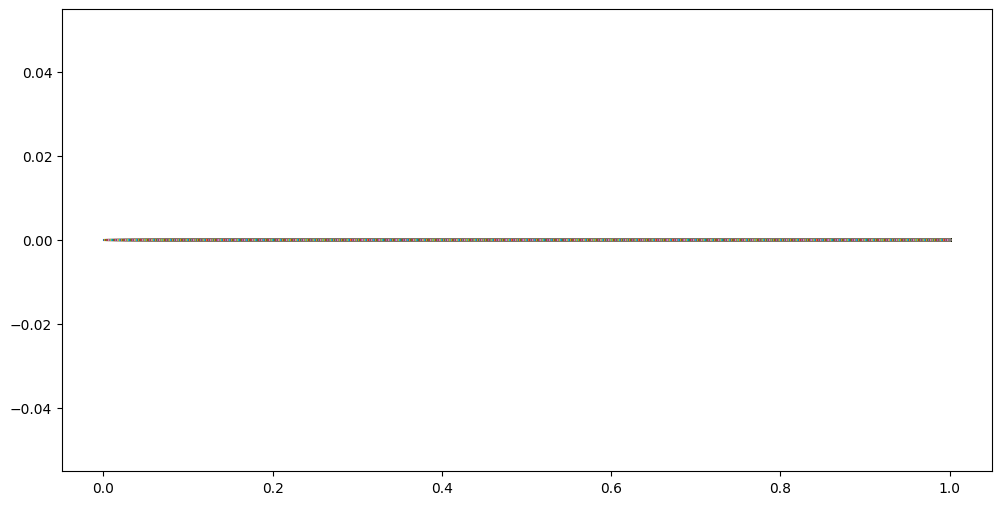

In [2]:
key = random.PRNGKey(0)
steps = 1000
samples = 5

H = 0.6

t, fbm = gen_elevation_profile(key, steps, H)
plt.figure(figsize=(12,6))
print(fbm)
for i in range(fbm.shape[0]):
    plt.plot(t, fbm[i], label=f"Sample {i}")

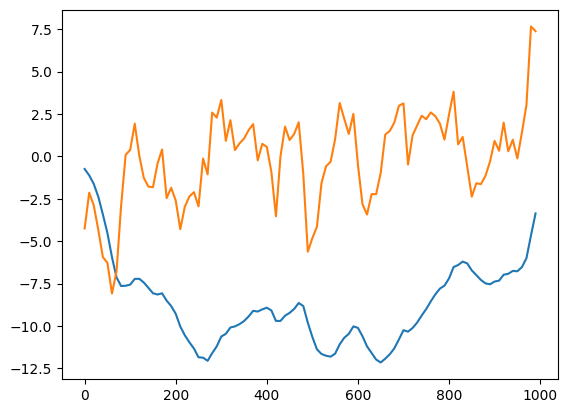

In [3]:
steps = 100
key = random.key(25)

def uniform_window(n):
    return jnp.ones(n)/n

def generate_basic_terrain(key, steps=100, yscale=1.0, xscale=10.0, window=uniform_window, window_size=5):
    key, split = random.split(key)
    v = random.normal(split, shape=(steps))
    y = jnp.cumsum(v) * yscale
    # smooth with a windowing function
    y_smooth = jnp.convolve(y, window(window_size), mode='same')
    # compute the x-values
    x = jnp.arange(steps) * xscale
    return x,y_smooth


x,y = generate_basic_terrain(key)
    
slope = jnp.atan(jnp.diff(y, prepend=0) / 10.0) * 180 / jnp.pi
plt.plot(x,y)
plt.plot(x, slope)

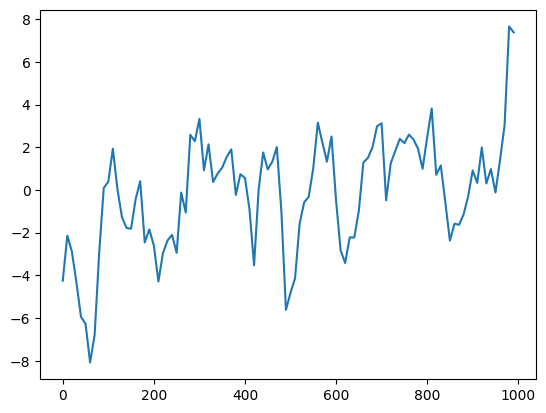

In [4]:
# we can compute the slope at any point along the terrain
plt.plot(x, slope)

In [5]:
%run ../src/solarcarsim/physsim.py

In [6]:
from functools import partial
import jax
p = CarParams()
print(p)


def control_fn(time):
    # for the first minute, go at 15 m/s
    return 10 + time * 10/60

def wrapper(curr_state, _):
    vel = control_fn(curr_state[1])
    next_state = forward(curr_state, 0.1, vel, p)
    return next_state, next_state

state_init = jnp.array([0.0, 0.0, 45.5e6])
_, out = jax.lax.scan(wrapper, state_init, None, length=1000)

CarParams(mass=800, frontal_area=1.3, drag_coeff=0.18, rolling_coeff=0.002, moter_eff=0.93, wheel_radius=0.23, max_speed=30.0, solar_area=5.0, solar_eff=0.2, n_motors=2, motor=MotorParams(kv=8.43, kt=1.1, resistance=100.0, friction_coeff=0.001, iron_coeff=0.001), battery=BatteryParams(shape=(36, 19), resistance=0.0126, initial_energy=66600.0))


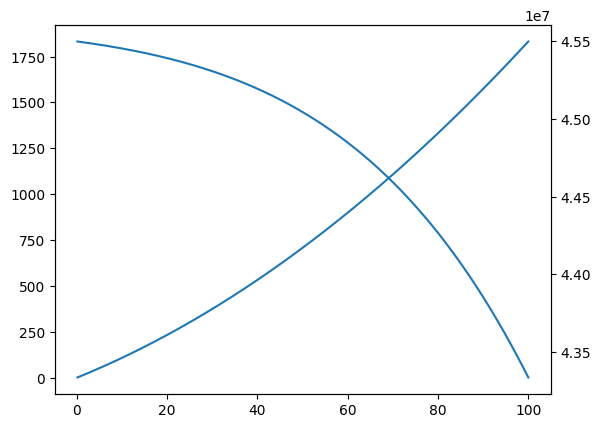

In [7]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
x = out[:,1]
ax1.plot(x, out[:,0], label="position")
ax2.plot(x, out[:,2], label="energy")


In [8]:
x = jnp.linspace(0,30, 1000)
dragf = drag_force(x, 1.3, 0.18, 1.184)

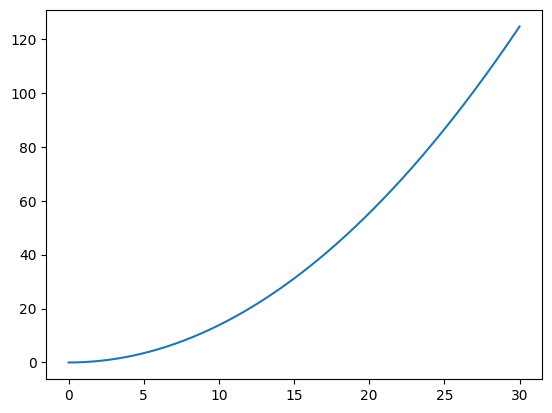

In [9]:
plt.plot(x, dragf)

In [10]:
%run ../src/solarcarsim/noise.py

In [11]:
key = random.key(123)
fractal_tex = generate_noise_texture(key, 256, 256, "fractal")

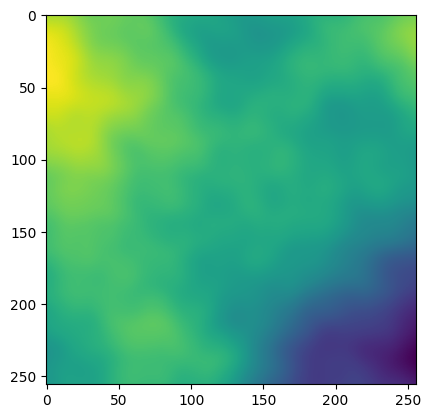

In [12]:
plt.imshow(fractal_tex)

In [13]:
import pyvista as pv
import numpy as np
a = np.array(fractal_tex)


In [14]:
tex = pv.numpy_to_texture(a)


/home/saji/Documents/Code/solarcarsim/.venv/lib/python3.12/site-packages/pyvista/plotting/texture.py:682: UserWarning: Expected `image` dtype to be ``np.uint8``. `image` has been copied and converted to np.uint8.
  warnings.warn(


/home/saji/Documents/Code/solarcarsim/.venv/lib/python3.12/site-packages/pyvista/core/utilities/points.py:55: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


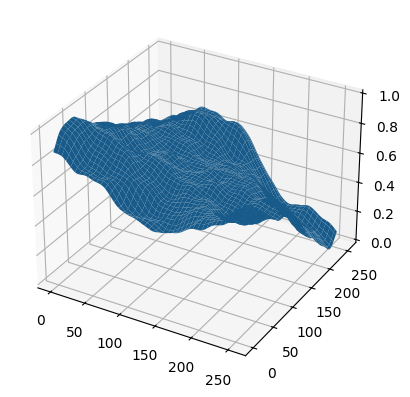

In [15]:
x = np.arange(0,256)
y = np.arange(0,256)
x, y = np.meshgrid(x, y)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(x,y,a)
grid=pv.StructuredGrid(x,y, a * 100)

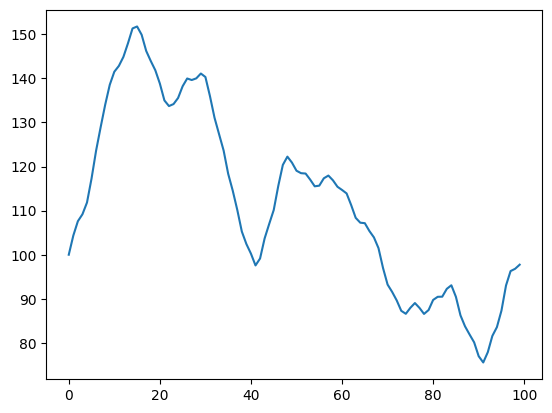

In [16]:
key = random.key(123)
key, subkey = random.split(key)
y = generate_elevation_profile(subkey, 100, scale=100)
plt.plot(y)

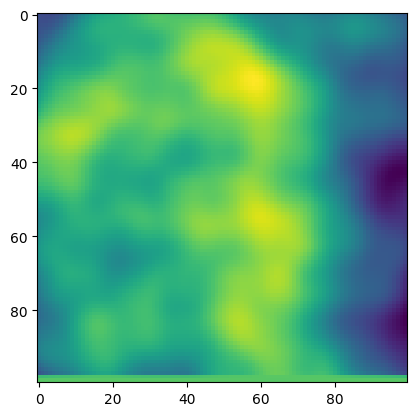

In [17]:
key, subkey = random.split(key)
y = generate_wind_field(subkey, 100, 100)
plt.imshow(y)

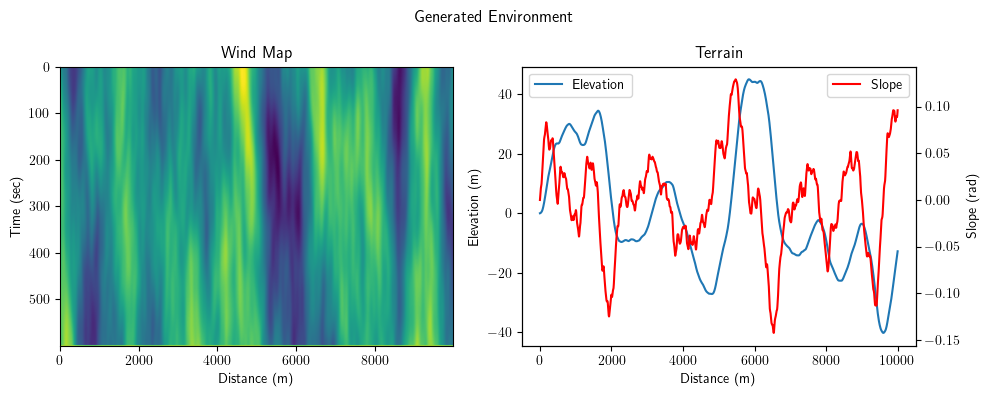

In [13]:
%run ../src/solarcarsim/physsim.py
from jax import random
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
})
wind, elevation, slope = make_environment(random.key(123))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
fig.set_tight_layout('auto')
fig.suptitle("Generated Environment")

ax1.imshow(wind, aspect='auto')
ax1.set_title("Wind Map")
ax1.set_ylabel("Time (sec)")
ax1.set_xlabel("Distance (m)")


ax2.set_title("Terrain")
ax_slope = ax2.twinx()

ax2.plot(elevation, label="Elevation")
ax2.set_ylabel("Elevation (m)")
ax2.set_xlabel("Distance (m)")
ax_slope.plot(slope, color='r', label='Slope')
ax_slope.set_ylabel("Slope (rad)")
ax2.legend(loc=2)
ax_slope.legend(loc=1)
fig.savefig("environment.pdf")

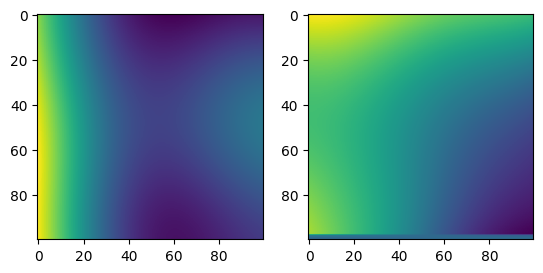

In [19]:
# testing the indexing into the wind array.
ax2.legend()
# given an array of shape (10,2)
# return an array of (10,100,100)
key = random.key(0)
@jit
def lookup(x):
    return lax.dynamic_slice(wind, x, (100, 100))
vlookup = vmap(lookup)
res = vlookup(jnp.array([[10,20], [9999, 600]]))

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(res[0])
ax2.imshow(res[1])

In [1]:
%run ../src/solarcarsim/simv1.py
import gymnasium as gym
from gymnasium.wrappers.jax_to_numpy import JaxToNumpy
from gymnasium.wrappers.vector import JaxToNumpy as VJaxToNumpy

In [2]:
env = SolarRaceV1()
wrapped_env = JaxToNumpy(env)
env.reset()
from stable_baselines3.common.env_checker import check_env
from gymnasium.utils.env_checker import check_env as gym_check_env
check_env(wrapped_env)
gym_check_env(wrapped_env)

/home/saji/Documents/Code/solarcarsim/.venv/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:271: UserWarning: Your observation wind has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(
/home/saji/Documents/Code/solarcarsim/.venv/lib/python3.12/site-packages/gymnasium/utils/env_checker.py:384: UserWarning: WARN: The environment (<JaxToNumpy<SolarRaceV1 instance>>) is different from the unwrapped version (<SolarRaceV1 instance>). This could effect the environment checker as the environment most likely has a wrapper applied to it. We recommend using the raw environment for `check_env` using `env.unwrapped`.
  logger.warn(
/home/saji/Documents/Code/solarcarsim/.venv/lib/python3.12/site-packages/gymnasium/utils/env_checker.py:434: UserWarning: WARN: Not able to test alternative render modes due to the environment not havi

In [25]:
# import a model and try it out!
from stable_baselines3 import PPO
model = PPO("MultiInputPolicy", wrapped_env, verbose=1)
model.learn(total_timesteps=1_000_000)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 601      |
|    ep_rew_mean     | 8.77e+11 |
| time/              |          |
|    fps             | 335      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2048     |
---------------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 601      |
|    ep_rew_mean          | 8.72e+11 |
| time/                   |          |
|    fps                  | 313      |
|    iterations           | 2        |
|    time_elapsed         | 13       |
|    total_timesteps      | 4096     |
| train/                  |          |
|    approx_kl            | 0.0      |
|    clip_fraction        | 0        |
|    clip_range           | 0.2      |
|    entropy_loss         | -1.42    |
|    explained_vari

KeyboardInterrupt: 

In [ ]:
pos = jnp.array([0])
time = jnp.array([0])
x = jnp.stack([pos,time], axis=1)
vlookup(x)

Array([[[-4.9999666, -5.031969 , -5.063982 , ..., -6.714849 ,
         -6.71299  , -6.7111654],
        [-4.9998884, -5.031891 , -5.0639033, ..., -6.705859 ,
         -6.7038655, -6.701909 ],
        [-4.9997377, -5.03174  , -5.0637527, ..., -6.6968226,
         -6.694696 , -6.692607 ],
        ...,
        [-4.8104963, -4.840162 , -4.869858 , ..., -6.505874 ,
         -6.499703 , -6.4934487],
        [-4.8117733, -4.8413825, -4.871023 , ..., -6.511339 ,
         -6.5052385, -6.499054 ],
        [-4.812991 , -4.8425455, -4.8721304, ..., -6.5165534,
         -6.510523 , -6.504408 ]]], dtype=float32)